## Analysis of IAV water availability by Growing Seasons calculation 

Search for LUMIP simulations and available models

In [1]:
import intake
import os
import glob

import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import seaborn as sns

import netCDF4
import numpy as np
import xarray as xr
import cftime
import pandas as pd

In [54]:
work = "locale" # or "levante"

if work == "levante":
    data_path = "/home/m/m301093/data/clean/"
    out_path = "/home/m/m301093/results_biophys/"
else:
    data_path = "G:/My Drive/MPIM/data/"
    out_path = "G:/My Drive/MPIM/Figures/"


### Functions

Mann-Whitney U test

In [3]:
#### --------- Mann-Whitney Test --------- ####
from scipy.stats import mannwhitneyu

# Test applied on a grid-cell basis. For every gid-cell, the statistical difference between two time series is computed.
# 1st time series: Nino years' (DS_models_hist_nino)
# 2nd time series: Reference climatology (DS_models_hist_clim or DS_models_hist_clim_neutral)  

## -- Function for grid-cell operations -- ##
def multi_apply_along_axis(func1d, axis, arrs, *args, **kwargs):
    """
    Given a function `func1d(A, B, C, ..., *args, **kwargs)`  that acts on 
    multiple one dimensional arrays, apply that function to the N-dimensional
    arrays listed by `arrs` along axis `axis`
    
    If `arrs` are one dimensional this is equivalent to::
    
        func1d(*arrs, *args, **kwargs)
    
    If there is only one array in `arrs` this is equivalent to::
    
        numpy.apply_along_axis(func1d, axis, arrs[0], *args, **kwargs)
        
    All arrays in `arrs` must have compatible dimensions to be able to run
    `numpy.concatenate(arrs, axis)`
    
    Arguments:
        func1d:   Function that operates on `len(arrs)` 1 dimensional arrays,
                  with signature `f(*arrs, *args, **kwargs)`
        axis:     Axis of all `arrs` to apply the function along
        arrs:     Iterable of numpy arrays
        *args:    Passed to func1d after array arguments
        **kwargs: Passed to func1d as keyword arguments
    """
    # Concatenate the input arrays along the calculation axis to make one big
    # array that can be passed in to `apply_along_axis`
    carrs = np.concatenate(arrs, axis)
    
    # We'll need to split the concatenated arrays up before we apply `func1d`,
    # here's the offsets to split them back into the originals
    offsets=[]
    start=0
    for i in range(len(arrs)-1):
        start += arrs[i].shape[axis]
        offsets.append(start)
            
    # The helper closure splits up the concatenated array back into the components of `arrs`
    # and then runs `func1d` on them
    def helperfunc(a, *args, **kwargs):
        arrs = np.split(a, offsets)
        return func1d(*[*arrs, *args], **kwargs)
    
    # Run `apply_along_axis` along the concatenated array
    return np.apply_along_axis(helperfunc, axis, carrs, *args, **kwargs)


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected

Multimodel hatching

In [4]:
def xr_multimodel_sign(xr_in, models):
    # Computes the Multimodel MEAN and STD
    # xr_in: list of xarray models
    mm = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override")
    
    std = xr.concat(xr_in, dim = "esm", coords = "minimal", compat = "override").std(dim = "esm")
    
    # Multimodel agreement in the sign of the sensitivity
    sign = xr.where(mm > 0, 1, -1)
    agreement = (np.abs(sign.sum(dim = "esm")/len(models)))
    
    mean = mm.mean(dim = "esm")
    return (mean, std, agreement)

Regrid 

In [5]:
import xesmf as xe

def xr_regrid(data, method, lon_bnds, lat_bnds, xres, yres):
    # Regrid XARRAY using xESMF library (https://xesmf.readthedocs.io/en/stable/index.html)
    # data: input data
    # method: "bilinear", "conservative", "conservative_normed", "patch", "nearest_s2d", "nearest_d2s"
    
    lonmin = lon_bnds[0]; lonmax = lon_bnds[1]
    latmin = lat_bnds[0]; latmax = lat_bnds[1]
    xr_out = xe.util.cf_grid_2d(lonmin, lonmax, xres, latmin, latmax, yres)
   
    regrid = xe.Regridder(data, xr_out, method)

    data_regrid = regrid(data, keep_attrs=True)

    return data_regrid

Regression

In [6]:
def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.Datarrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provied in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, and standard error on regression
    between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    #1. Ensure that the data are properly alinged to each other. 
    x,y = xr.align(x,y)
    
    #2. Add lag information if any, and shift the data accordingly
    if lagx!=0:
        #If x lags y by 1, x must be shifted 1 step backwards. 
        #But as the 'zero-th' value is nonexistant, xr assigns it as invalid (nan). Hence it needs to be dropped
        x   = x.shift(time = -lagx).dropna(dim='time')
        #Next important step is to re-align the two datasets so that y adjusts to the changed coordinates of x
        x,y = xr.align(x,y)

    if lagy!=0:
        y   = y.shift(time = -lagy).dropna(dim='time')
        x,y = xr.align(x,y)
 
    #3. Compute data length, mean and standard deviation along time axis for further use: 
    n     = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd  = x.std(axis=0)
    ystd  = y.std(axis=0)
    
    #4. Compute covariance along time axis
    cov   =  np.sum((x - xmean)*(y - ymean), axis=0)/(n)
    
    #5. Compute correlation along time axis
    cor   = cov/(xstd*ystd)
    
    #6. Compute regression slope and intercept:
    slope     = cov/(xstd**2)
    intercept = ymean - xmean*slope
    y_pred =  intercept + slope*x
    res = y - y_pred

    #7. Compute P-value and standard error
    #Compute t-statistics
    tstats = cor*np.sqrt(n-2)/np.sqrt(1-cor**2)
    stderr = slope/tstats
    
    from scipy.stats import t
    pval   = t.sf(tstats, n-2)*2
    pval   = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    #return cov,cor,slope,intercept,pval,stderr
    results = {}
    results["cor"] = cor
    results["coef"] = slope
    results["pval"] = pval
    return results

Seasonal means

In [7]:
# Wrap it into a simple function
def season_mean(ds, calendar="standard"):
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = ds.time.dt.days_in_month

    # Calculate the weights by grouping by 'time.season'
    weights = (
        month_length.groupby("time.season") / month_length.groupby("time.season").sum()
    )

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * weights).groupby("time.season").sum(dim="time")

Spatial mean

In [8]:
def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

## Import preprocessed data

In [9]:
models = [ "ACCESS-ESM1-5", "CanESM5", "IPSL-CM6A-LR", "MPI-ESM1-2-LR", "UKESM1-0-LL", ]

**Biogeophysical variables:** \
tas = 2-m air temperature\
ts = surface temperature\
rlds = downwelling longwave\
rsds = downwelling shortwave\
rsus = upwelling shortwave\
hfls = latent heat flux upward\
hfss = sensible heat flux upward\
huss = surface air specific humidity \
ps = surface pressure 

CanESM5 don't provide hfls (Latent Heat)


In [10]:
scenario = 'ssp126Lu'
xr_aff_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff_pft.append(content)


scenario = 'ssp370'
xr_ctl_pft = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '_pft.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl_pft.append(content)


In [11]:
scenario = 'ssp126Lu'
xr_aff = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_aff.append(content)


scenario = 'ssp370'
xr_ctl = []
for i,mm in enumerate(models):
    filepath = glob.glob(os.path.join(data_path + 'xr_' + scenario + "_" + mm + '.nc'))[0]                                       ## List of files sorted by name
    content = xr.open_dataset(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"],engine = 'netcdf4',chunks={"time": 240})
    xr_ctl.append(content)


Preprocessing

In [12]:
# CanESM5 does not provide Latent Heat
# We derive it as Rn - H (ignoring Ground Heat fluxes that are negligible over land)

xr_ctl[4]["hfls"] = (xr_ctl[4].rsds - xr_ctl[4].rlds) - xr_ctl[4].hfss
xr_aff[4]["hfls"] = (xr_aff[4].rsds - xr_aff[4].rlds) - xr_aff[4].hfss

# Rename ta to tas 
xr_aff[4] = xr_aff[4].rename({"ta":"tas"})
xr_ctl[4] = xr_ctl[4].rename({"ta":"tas"})

# Select the first pressure level
xr_aff[4] = xr_aff[4].isel(plev = 0)
xr_ctl[4] = xr_ctl[4].isel(plev = 0)

# Try to interpolate surface temperature for CanESM5
xr_ctl[4]["tas"] = (xr_ctl[4].ts + xr_ctl[4].tas)/2
xr_aff[4]["tas"] = (xr_aff[4].ts + xr_aff[4].tas)/2


In [13]:
# Convert pr and evspsbl from kg m-2 s-1 to mm month-1
for i,mm in enumerate(models):
    xr_ctl[i]["pr"] = xr_ctl[i].pr*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["pr"] = xr_aff[i].pr*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["pr"].attrs=dict(units="mm/months")
    xr_aff[i]["pr"].attrs=dict(units="mm/months")

    xr_ctl[i]["evspsbl"] = xr_ctl[i].evspsbl*86400* xr_ctl[i].time.dt.days_in_month
    xr_aff[i]["evspsbl"] = xr_aff[i].evspsbl*86400* xr_aff[i].time.dt.days_in_month
    
    xr_ctl[i]["evspsbl"].attrs=dict(units="mm/months")
    xr_aff[i]["evspsbl"].attrs=dict(units="mm/months")
    
    xr_aff[i]["albedo"] = xr_aff[i].rsus / xr_aff[i].rsds
    xr_ctl[i]["albedo"] = xr_ctl[i].rsus / xr_ctl[i].rsds
    
    

### PET estimation according to Priestley-Taylor

In [14]:
Cp = 1.0051*10**(-3)   # Specific heat of air at constant pressure (C_p)in MJ/(kg K)
Lv = 2.45              # Latent Heat of Vaporization for Water.  FAO uses constant 2.45 MJ/kg


In [15]:
def PriestleyTaylor(xr, alpha=1.26):
    # From https://www.nature.com/articles/s41597-023-02290-0
    '''Calculate Priestley-Taylor potential evapotranspiration for the given dictionary of input files'''
    
    # Convert to Celsius if temperature is in Kelvin
    # if xr['ts'].attrs['units'] == 'K':
    ts=xr['ts']-273.15

    # Net radiation = H + LE
    Rn = xr.hfss + xr.hfls
    
    # Psychometric constant
    psy = Cp*xr.ps/(1000*Lv*.622)                             # kPa
    
    # Saturation Vapour Pressure
    sat = (0.61078**(17.27*(ts)/(ts+237.3)))            # kPa
    
    # Delta
    delta = 4098*sat/((ts+237.3)**2)                     # kPa/K
    
    # Calculate PET using the Priestley-Taylor formulation with constant alpha (defalut alpha = 1.26)
    xr['pet'] = (alpha*delta*Rn)/(Lv*(delta+psy))             # mm/month

    # Mask out the ocean
    mask = np.ma.masked_equal(xr.lai, np.nan) 
    xr['pet'] = xr['pet'] * mask

    # Define variable attributes
    xr['pet'].attrs['units'] = 'mm month-1'
    xr['pet'].attrs['short_name'] = 'PET'
    xr['pet'].attrs['long_name'] = 'Priestley-Taylor Potential Evapotranspriation'
    xr['pet'].attrs['description'] = 'Priestley-Taylor Potential Evapotranspiration computed using formulation described in Priestley & Taylor (1972) with alpha = '+str(alpha)
    
    # # Aridity Index
    # xr['ai'] = xr['pet']*xr['pr']**-1
    # xr['ai'].attrs['units'] = 'mm month-1'
    # xr['ai'].attrs['short_name'] = 'AI'
    # xr['ai'].attrs['long_name'] = 'Aridity Index'
    # xr['ai'].attrs['description'] = 'PET/P'
      
    return xr

In [16]:
for i, mm in enumerate(models):
    PriestleyTaylor(xr_ctl[i], alpha=1.26)
    PriestleyTaylor(xr_aff[i], alpha=1.26) 

### Mask of $\Delta$treeFrac

In [17]:
xr_delta = []
xr_delta_pft = []
for i,mm in enumerate(models):
    xr_delta.append(xr_aff[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))
    xr_delta_pft.append(xr_aff_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time") - xr_ctl_pft[i].sel(time = slice("2071-01","2100-12")).mean(dim = "time"))

In [18]:
%%capture

# masking regions of treefrac increase or decrease
mask_treefrac_pos = []
mask_treefrac_neg = []

for m,_ in enumerate(models):
    
    # identify regions with 5%+ and 5%- treefrac
    mask_treefrac_pos.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] > 10))
    mask_treefrac_neg.append(xr_delta_pft[m]["treeFrac"].where(xr_delta_pft[m]["treeFrac"] <- 10))


### Water-Energy limitation

In [19]:
def regime_limit(dataset):
    cor_pr = lag_linregress_3D(dataset['hfls'], dataset['pr'])['cor'].compute()
    cor_ts = lag_linregress_3D(dataset['hfls'], dataset['ts'])['cor'].compute()
    
    water_limited = dataset.isel(time = -1).where(cor_pr > cor_ts, drop=True)["lai"]
    energy_limited = dataset.isel(time = -1).where(cor_pr < cor_ts, drop=True)["lai"]
    
    # Ensure computation and time slice selection
    return water_limited, energy_limited

In [20]:
mask_aff_water = []
mask_aff_energy = []
mask_ctl_water = []
mask_ctl_energy = []
for i, mm in enumerate(models):
    water, energy = regime_limit(xr_aff[i])
    mask_aff_water.append(water)
    mask_aff_energy.append(energy)
    
    water, energy = regime_limit(xr_ctl[i])
    mask_ctl_water.append(water)
    mask_ctl_energy.append(energy)

## Surface Energy Balance (SEB) decomposition

Taking the difference between the biogeophysical variables of ssp370-ssp126 and ssp370 \
Compute the Surface Energy Balance Decomposition to estimate the contribution to temperature.

The SEB equation can be decomposed as follows:

\begin{equation}
\Delta T_{\text{s}} = \frac{1}{{4 \varepsilon \sigma T_{\text{s}}^3}_{\text{ssp370}}} \cdot (\Delta {SW_{net}} + \Delta LW_{in} - \Delta H - \Delta \lambda E - \Delta G)
\end{equation}

that by decomposing $\Delta {SW_{net}}$ becomes:

\begin{equation}
\Delta T_{\text{s}} = \frac{1}{{4 \varepsilon \sigma T_{\text{s}}^3}_{\text{ssp370}}} \cdot (-SW_{in}\Delta {\alpha_{s}} + (1-\alpha_{ssp370})\Delta SW_{in} + \Delta LW_{in} - \Delta H - \Delta \lambda E - \Delta G)
\end{equation}

we ignore surface emissivity changes.

In [22]:
# Define Stefan-Boltzmann Constant (Wm^-2K^-4)
# Define Emissivity Constant
# Define air density Constant (Kgm^-3) (dry air, 0°C, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6764509/)
# Define specific heat content (JKg^-1K^-1) (dry air, =0°C, https://pubs.aip.org/asa/jasa/article/76/2/555/669652/Variation-of-specific-heats-and-of-specific-heat)

sigma = 5.67*10**(-8)
eps = 0.97
rho = 1.2930
Cp = 1.0051*10**(3)

In [23]:
# Compute SEB on the last 30-yrs period (2071 - 2100)

dT_seb_esm = []
dT_model_esm = []
seb_effect_esm = []

for i,mm in enumerate(models):
    seb_effects = xr.Dataset()
    
    xr_aff_seb = xr_aff[i]
    xr_ctl_seb = xr_ctl[i] 

    factor = 1/(4*sigma*eps*xr_ctl_seb.ts**(3))

    Rn_aff = (xr_aff_seb.rsds - xr_aff_seb.rsus) + eps*xr_aff_seb.rlds - eps*sigma*xr_aff_seb.ts**(4)
    Rn_ctl = (xr_ctl_seb.rsds - xr_ctl_seb.rsus) + eps*xr_ctl_seb.rlds - eps*sigma*xr_ctl_seb.ts**(4)

    G_aff = Rn_aff - xr_aff_seb.hfss - xr_aff_seb.hfls
    G_ctl = Rn_ctl - xr_ctl_seb.hfss - xr_ctl_seb.hfls

    delta_Snet = factor * ((xr_aff_seb.rsds - xr_aff_seb.rsus) - (xr_ctl_seb.rsds - xr_ctl_seb.rsus))
    delta_Sd = factor * (xr_aff_seb.rsds - xr_ctl_seb.rsds)
    delta_Ld = factor * (xr_aff_seb.rlds - xr_ctl_seb.rlds)
    delta_H = -factor * (xr_aff_seb.hfss - xr_ctl_seb.hfss)
    delta_LE = -factor * (xr_aff_seb.hfls - xr_ctl_seb.hfls)
    delta_albedo = -factor * ((xr_aff_seb.rsus/xr_aff_seb.rsds) - (xr_ctl_seb.rsus/xr_ctl_seb.rsds))

    deltaG = -factor * (G_aff - G_ctl)

    dT_seb = xr_ctl_seb.rsds*delta_albedo + (1-(xr_ctl_seb.rsus/xr_ctl_seb.rsds))*delta_Sd + delta_Ld + delta_H + delta_LE + deltaG
    dT_model = (xr_aff_seb.ts - xr_ctl_seb.ts)

    seb_effects["albedo"] = xr_ctl_seb.rsds*delta_albedo
    seb_effects["Sd"] = (1-(xr_ctl_seb.rsus/xr_ctl_seb.rsds))*delta_Sd
    seb_effects["Ld"] = delta_Ld
    seb_effects["H"] = delta_H
    seb_effects["LE"] = delta_LE
    # deltaG]
    
    dT_seb_esm.append(dT_seb)
    dT_model_esm.append(dT_model)
    seb_effect_esm.append(seb_effects)
# Clean the xarray
# T_seb = T_seb.drop(labels = ["time_bnds","lat_bnds","lon_bnds"])
# T_model = T_model.drop(labels = ["time_bnds","lat_bnds","lon_bnds"])

In [125]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

df_seb_pos_water = []
df_seb_pos_energy = []
for i,mm in enumerate(models):
    content = {}
    content1 = {}
    for bb,b in enumerate(boxes):
        content[regions[bb]] = ((seb_effect_esm[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_pos[i].notnull()).where(mask_aff_water[i].notnull()).mean(dim = "time"))
                                .compute()).to_dataframe().drop(columns = ["height"])
        content1[regions[bb]] = ((seb_effect_esm[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_pos[i].notnull()).where(mask_aff_energy[i].notnull()).mean(dim = "time"))
                                .compute()).to_dataframe().drop(columns = ["height"])
    
        if hasattr(content[regions[bb]], "plev"):
            content[regions[bb]] = content[regions[bb]].drop(columns = ["plev"])
            content1[regions[bb]] = content1[regions[bb]].drop(columns = ["plev"])
        if hasattr(content[regions[bb]], "type"):
            content[regions[bb]] = content[regions[bb]].drop(columns = ["type"])
            content1[regions[bb]] = content1[regions[bb]].drop(columns = ["type"])
    
    df_seb_pos_water.append(content)
    df_seb_pos_energy.append(content1)

Text(0.45, 1.05, 'positive treeFrac >10%')

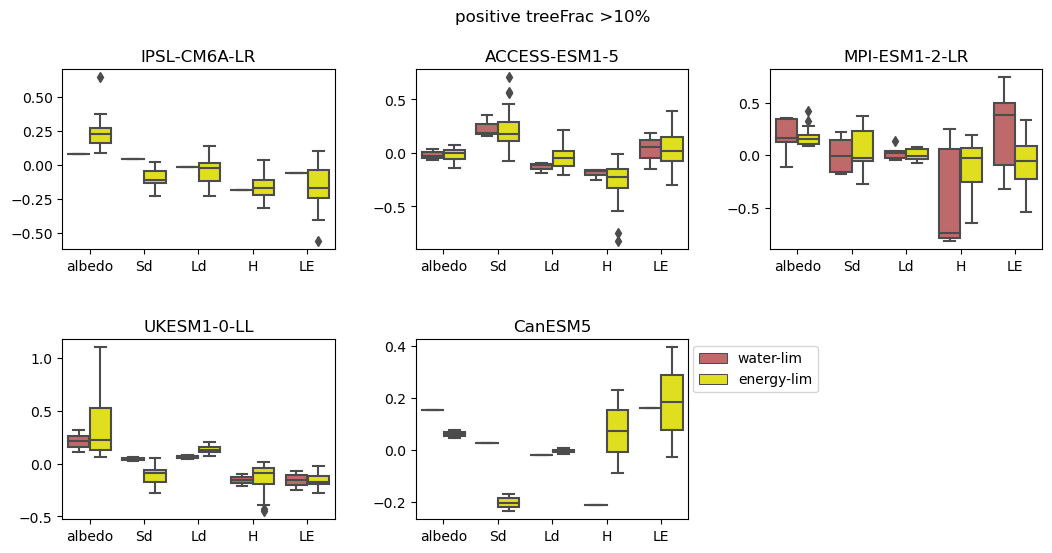

In [145]:
# from statannot import add_stat_annotation

# fig, ax = plt.subplots(figsize=(8, 6))
# sns.boxplot(data=df, x='variables', y='value', hue='regime', palette=['indianred', 'yellow'], ax=ax)
# add_stat_annotation(ax, data=df, x='variables', y='value', hue='regime',
#                     box_pairs=[(("albedo", "water-lim"), ("albedo", "energy-lim")), (("Sd", "water-lim"), ("Sd", "enegy-lim")), (("Ld", "water-lim"), ("Ld", "enegy-lim")), 
#                                (("H", "water-lim"), ("H", "enegy-lim")), (("LE", "water-lim"), ("LE", "energy-lim"))],
#                     test='Mann-Whitney', text_format='star', loc='outside', comparisons_correction = "bonferroni", verbose=2)

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    df = pd.DataFrame([[label, val, 'water-lim'] for label, values in df_seb_pos_water[m]["SE Asia"].items() for val in values]
                  + [[label, val, 'energy-lim'] for label, values in df_seb_pos_energy[m]["SE Asia"].items() for val in values],
                  columns=['variables', 'value', 'regime'])
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.boxplot(data=df, x='variables', y='value', hue='regime', palette=['indianred', 'yellow'])

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.boxplot(data=df, x='variables', y='value', hue='regime', palette=['indianred', 'yellow'])

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("positive treeFrac >10%", y =1.05, x = 0.45)

In [42]:
df_seb_pos_water = pd.concat(df_seb_pos_water, axis = 0)
df_seb_pos_water = pd.melt(df_seb_pos_water, ignore_index=False, id_vars="model", var_name="regions")

df_seb_pos_energy = pd.concat(df_seb_pos_energy, axis = 0)
df_seb_pos_energy = pd.melt(df_seb_pos_energy, ignore_index=False, id_vars="model", var_name="regions")

Text(0.45, 1.05, 'positive treeFrac >10%')

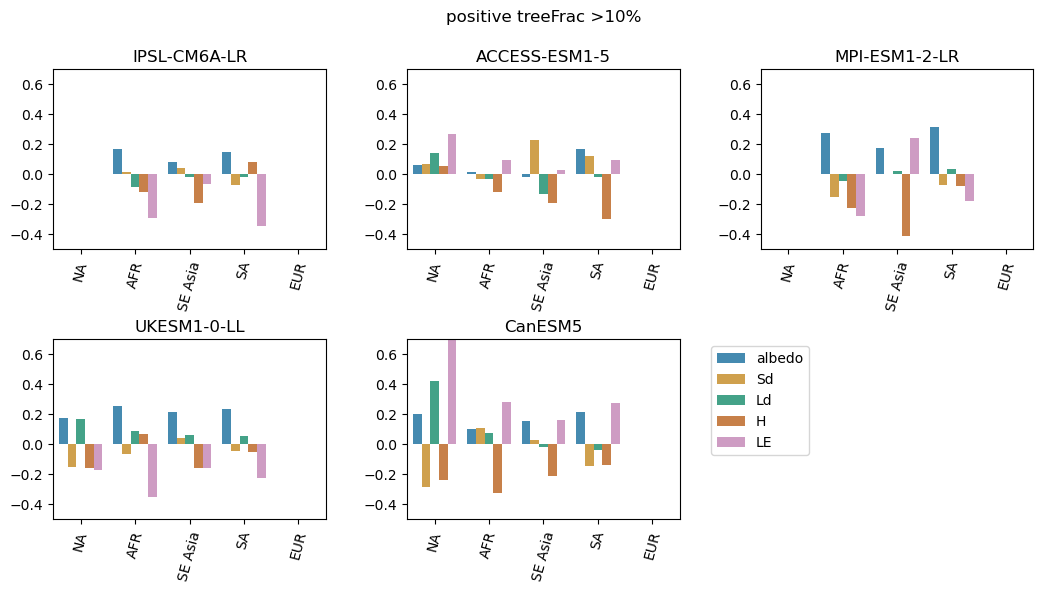

In [43]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=df_seb_pos_water[df_seb_pos_water["model"] == models[m]], hue = df_seb_pos_water[df_seb_pos_water["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8,
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=df_seb_pos_water[df_seb_pos_water["model"] == models[m]], hue = df_seb_pos_water[df_seb_pos_water["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8, 
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("positive treeFrac >10%", y =1.05, x = 0.45)

## SEB components in water vs energy-limited regions

In [95]:
seb_pos_water_mean = []
seb_pos_energy_mean = []

# mapping = {0: 'lai', 1: 'ts', 2: 'pr', 3: 'rsds'}
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    masked = seb_effect_esm[m].where(mask)
    masked1 = seb_effect_esm[m].where(mask1)
    content = []; content1 = []
    for v in list(seb_effect_esm[m].data_vars)[:]:
        content.append(masked[v].weighted(cell_weight(masked)).mean(["time", "lat","lon"]).data)
        content1.append(masked1[v].weighted(cell_weight(masked1)).mean(["time", "lat","lon"]).data)
    content = np.array(content)
    content1 = np.array(content1)
    seb_pos_water_mean.append(content); 
    seb_pos_energy_mean.append(content1);
    
seb_pos_water_mean = pd.DataFrame(seb_pos_water_mean, columns = list(seb_effect_esm[m].data_vars)[:], index = models)
seb_pos_energy_mean = pd.DataFrame(seb_pos_energy_mean, columns = list(seb_effect_esm[m].data_vars)[:], index = models)

/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/sw/spack-levante/mambaforge-22.9.0-2-Linux-x86_64-kptncg/lib/python3.10/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered i

In [98]:
seb_pos_water_mean = pd.melt(seb_pos_water_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
seb_pos_water_mean["regime"] = "water-lim"

seb_pos_energy_mean = pd.melt(seb_pos_energy_mean.reset_index().rename(columns={'index': 'models'}), id_vars = "models")
seb_pos_energy_mean["regime"] = "energy-lim"

In [105]:
seb_pos_mean = pd.concat([seb_pos_water_mean, seb_pos_energy_mean], axis = 0)

Text(0.45, 1.05, 'dSEB/dtreeFrac (treeFrac >10%)')

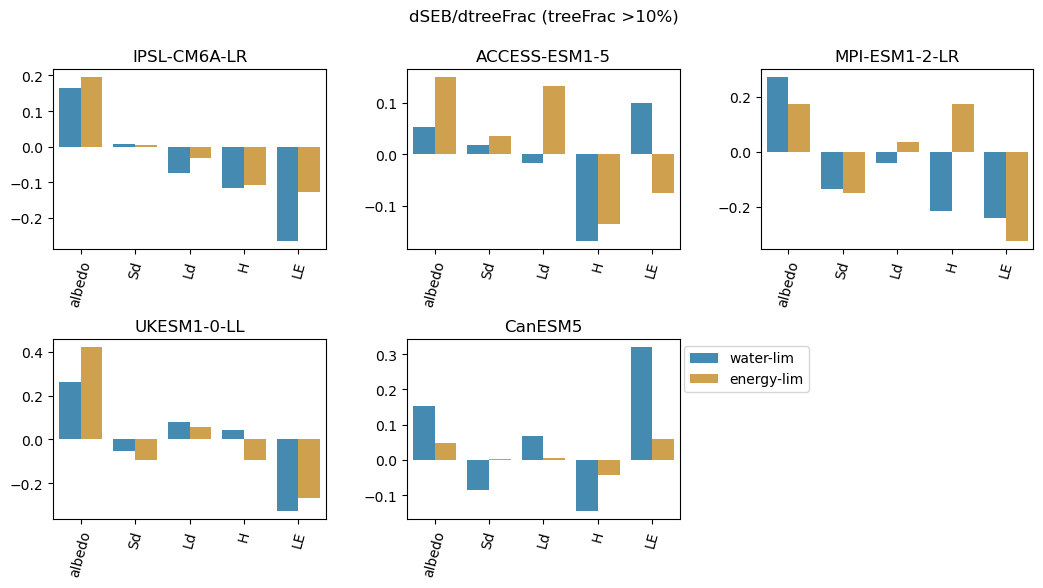

In [109]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=seb_pos_mean[seb_pos_mean["models"] == models[m]], hue = seb_pos_mean[seb_pos_mean["models"] == models[m]].regime,# errorbar=("pi", 50),
            x="variable", y="value",
            palette="colorblind", alpha=.8,
        )
        axs.set_xticklabels(list(seb_effect_esm[m].data_vars), rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=seb_pos_mean[seb_pos_mean["models"] == models[m]], hue = seb_pos_mean[seb_pos_mean["models"] == models[m]].regime,# errorbar=("pi", 50),
            x="variable", y="value",
            palette="colorblind", alpha=.8, 
        )
        axs.set_xticklabels(list(seb_effect_esm[m].data_vars), rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("dSEB/dtreeFrac (treeFrac >10%)", y =1.05, x = 0.45)

In [35]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

treeFrac_pos_esm = []
treeFrac_neg_esm = []
for i,mm in enumerate(models):
    content = []
    content1 = []
    for bb,b in enumerate(boxes):
        content.append((xr_delta_pft[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_pos[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]))
        content1.append((xr_delta_pft[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_neg[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]))
    content = pd.concat(content,axis = 1)
    content1 = pd.concat(content1,axis = 1)
    
    if hasattr(content, "plev"):
        content = content.drop(columns = ["plev"])
        content1 = content1.drop(columns = ["plev"])
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    
    content["model"] = models[i]
    content1["model"] = models[i]
    
    treeFrac_pos_esm.append(content)
    treeFrac_neg_esm.append(content1)

treeFrac_pos_esm = pd.concat(treeFrac_pos_esm, axis = 0)
treeFrac_pos_esm = pd.melt(treeFrac_pos_esm, ignore_index=False, id_vars="model", var_name="regions")

treeFrac_neg_esm = pd.concat(treeFrac_neg_esm, axis = 0)
treeFrac_neg_esm = pd.melt(treeFrac_neg_esm, ignore_index=False, id_vars="model", var_name="regions")

In [55]:
treeFrac_pos_esm = treeFrac_pos_esm.reset_index()
treeFrac_neg_esm = treeFrac_neg_esm.reset_index()

Text(0.5, 1.05, 'dtreefrac')

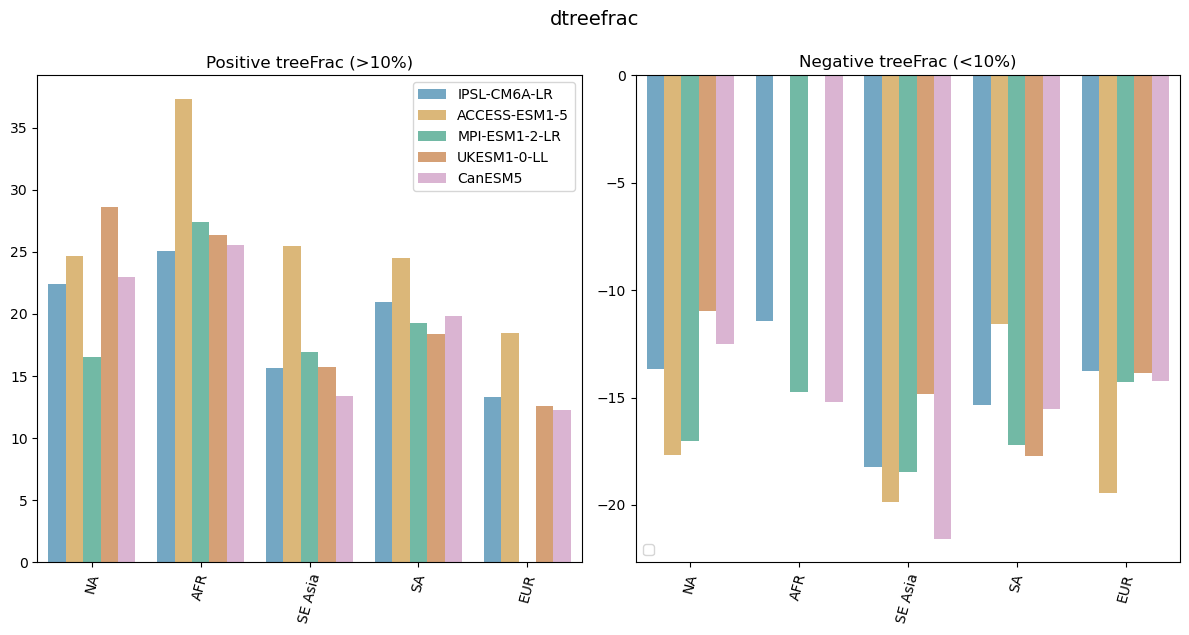

In [57]:
import seaborn as sns

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
        data=treeFrac_pos_esm[treeFrac_pos_esm["variable"] == "treeFrac"], hue = "model",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(regions, rotation = 75)
# ax0.set_ylim(-0.25, 0.25)
ax0.legend(loc='upper right', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
ax0.set_title("Positive treeFrac (>10%)")


ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
        data=treeFrac_neg_esm[treeFrac_neg_esm["variable"] == "treeFrac"], hue = "model",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6,
    )
ax1.set_xticklabels(regions , rotation = 75)
# ax1.set_ylim(-0.25, 0.25)
ax1.legend("")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Negative treeFrac (<10%)")

fig.tight_layout()
title = 'dtreefrac'
fig.suptitle(title, y = 1.05, fontsize = 14)

## Temperature change in areas of $\Delta$treefrac

In [ ]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_title('Longitude and Latitude Boxes')
ax.coastlines()

# Define boxes with (lon_min, lon_max, lat_min, lat_max)
boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (0, 70, 40, 70)       # Eurasia
]

    # Loop over the boxes and add them to the map
for lon_min, lon_max, lat_min, lat_max in boxes:
        ax.add_patch(plt.Rectangle((lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
                                   fill=None, edgecolor='red', linewidth=2, transform=ccrs.PlateCarree()))

    # Set the extent (min_lon, max_lon, min_lat, max_lat) of the map
    # Here we set it to a wide range to see all boxes, adjust as needed
ax.set_extent([-180, 180, -60, 90], crs=ccrs.PlateCarree())

    # Show the plot
plt.show()

Where temperature difference is significant

In [21]:
xr_mw_ts = []
for i,mm in enumerate(models):
    
    mw = multi_apply_along_axis(mannwhitneyu, 0, [xr_aff[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0), 
                                                  xr_ctl[i].sel(time = slice("2071-01","2100-12")).ts.fillna(0)])[1]
    mw_xr = xr.DataArray(mw, dims=["lat","lon"], coords=dict(lon = (xr_aff[i].lon.values), lat= (xr_ctl[i].lat.values)))
    
    xr_mw_ts.append(mw_xr)

In [ ]:
# Where dTs is significant and treeFrac >10%

cond1 = mask_treefrac_neg[4].notnull()
cond2 = xr_mw_ts[4].where(xr_mw_ts[4] < 0.1).notnull()
combined_mask = cond1 & cond2
dT_model_esm[4].sel(time = slice("2070-01", "2100-12")).mean(dim = "time").where(combined_mask).plot()

In [ ]:
cmap = "RdBu_r"
clevs = np.arange(-1,1.1,0.05)

width_inch = 12
height_inch = 6

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(width_inch, height_inch), subplot_kw={'projection': ccrs.PlateCarree()})
axs = axs.flatten()

for i in np.arange(len(models)):
    
    data = dT_model_esm[i].sel(time = slice("2070-01", "2100-12")).mean(dim = "time").where(mask_treefrac_pos[i].notnull())
    lats = data.lat
    # Add the cyclic point
    data,lons=add_cyclic_point(data,coord=data['lon'])

    map = axs[i].contourf(lons, lats, data, clevs, transform = ccrs.PlateCarree(), cmap=cmap, extend = "both")
    # axs[i].add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '50m', edgecolor='face', facecolor="white"))
    axs[i].coastlines()
    axs[i].set_title(models[i])

    # Longitude labels
    axs[i].set_xticks(np.arange(-180,181,90), crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter()
    axs[i].xaxis.set_major_formatter(lon_formatter)

    # Latitude labels
    axs[i].set_yticks(np.arange(-60,91,45), crs=ccrs.PlateCarree())
    lat_formatter = cticker.LatitudeFormatter()
    axs[i].yaxis.set_major_formatter(lat_formatter)
    
    # Delete the unwanted axes
for i in [5]:
    fig.delaxes(axs[i])

fig.subplots_adjust(bottom=0.2, top=2, left=0.1, right=0.8, wspace=0.0, hspace=0.2)

cb_ax = fig.add_axes([0.325, 0.1, 0.4, 0.02])
cbar = plt.colorbar(map, cax=cb_ax, extend='both', orientation='horizontal', fraction=0.046, pad=0.04)
title = "Ts change in areas of treeFrac >10%"
fig.suptitle(title, y = .85)
fig.tight_layout()

    # output_file = os.path.join(out_path, title) + ".png"
    # plt.savefig(output_file, bbox_inches='tight')

plt.show()
plt.close()


In [58]:
%%time
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]
Ts_pos_esm = []
Ts_neg_esm = []
for i in np.arange(len(models)):
    content_pos = []
    content_neg = []
    for b in boxes:
        content_pos.append(dT_model_esm[i].sel(time = slice("2070-01", "2100-12")).mean(dim = "time").where(mask_treefrac_pos[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
        content_neg.append(dT_model_esm[i].sel(time = slice("2070-01", "2100-12")).mean(dim = "time").where(mask_treefrac_neg[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
    Ts_pos_esm.append(pd.DataFrame(content_pos))
    Ts_neg_esm.append(pd.DataFrame(content_neg))


Ts_pos_esm = pd.concat(Ts_pos_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
Ts_neg_esm = pd.concat(Ts_neg_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
Ts_pos_esm["regions"] = Ts_pos_esm.index
Ts_neg_esm["regions"] = Ts_neg_esm.index
Ts_pos_esm = pd.melt(Ts_pos_esm, id_vars="regions", var_name="esm")
Ts_neg_esm = pd.melt(Ts_neg_esm, id_vars="regions", var_name="esm")

CPU times: user 56 s, sys: 2.14 s, total: 58.1 s
Wall time: 54.4 s


Text(0.5, 1.05, 'Temperature change in areas of treeFrac change')

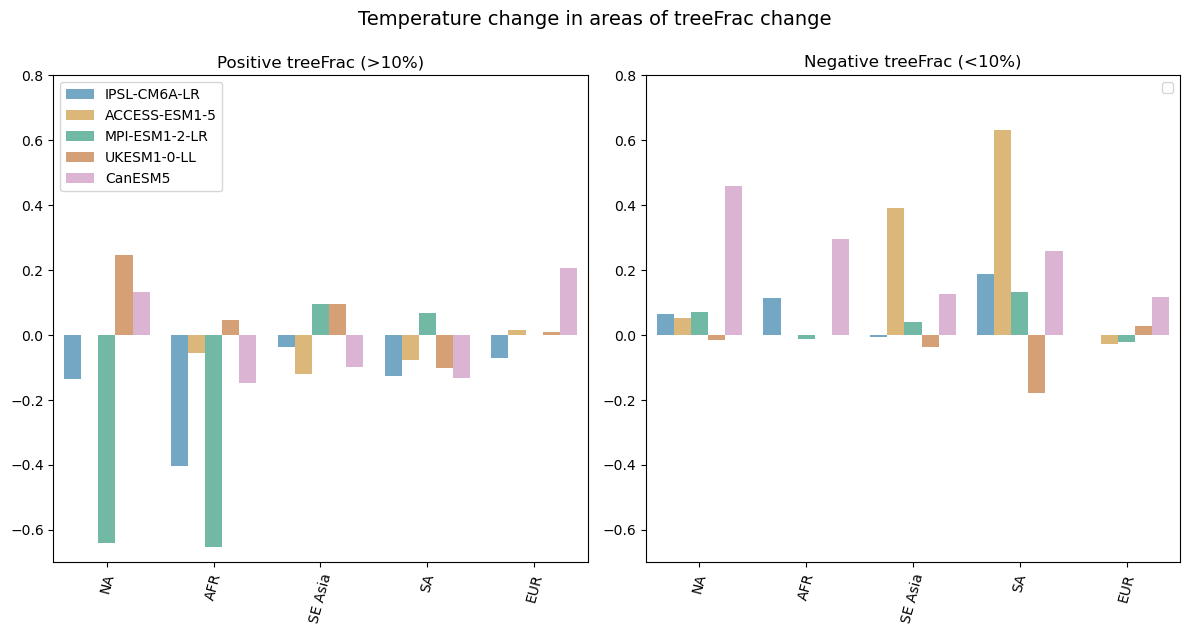

In [59]:
import seaborn as sns

fig = plt.figure(figsize=(12, 6))

ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
        data=Ts_pos_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(regions, rotation = 75)
ax0.set_ylim(-0.7, 0.8)
ax0.legend(loc='upper left', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
ax0.set_title("Positive treeFrac (>10%)")


ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
        data=Ts_neg_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6, 
    )
ax1.set_xticklabels(regions , rotation = 75)
ax1.set_ylim(-0.7, 0.8)
ax1.legend("")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Negative treeFrac (<10%)")

fig.tight_layout()
title = 'Temperature change in areas of treeFrac change'
fig.suptitle(title, y = 1.05, fontsize = 14)

## reg(Ts, $\Delta$treefrac)

In [17]:
%%capture

# dTs_tree: sensitivity of Ts to treefrac change
dTs_tree = []
dTs_tree_seas = []
for m,_ in enumerate(models):
    dtree_seas = dict()
    # difference in treeFrac in aff vs ctl
    dtree_frac = (xr_aff_pft[m]["treeFrac"] - xr_ctl_pft[m]["treeFrac"])
    
    dtree_seas["DJF"] = lag_linregress_3D(dT_model_esm[m].sel(time=dT_model_esm[m].time.dt.season=="DJF"), dtree_frac.sel(time=dT_model_esm[m].time.dt.season=="DJF"))
    dtree_seas["MAM"] = lag_linregress_3D(dT_model_esm[m].sel(time=dT_model_esm[m].time.dt.season=="MAM"), dtree_frac.sel(time=dT_model_esm[m].time.dt.season=="MAM"))
    dtree_seas["JJA"] = lag_linregress_3D(dT_model_esm[m].sel(time=dT_model_esm[m].time.dt.season=="JJA"), dtree_frac.sel(time=dT_model_esm[m].time.dt.season=="JJA"))
    dtree_seas["SON"] = lag_linregress_3D(dT_model_esm[m].sel(time=dT_model_esm[m].time.dt.season=="SON"), dtree_frac.sel(time=dT_model_esm[m].time.dt.season=="SON"))
    
    ## Linear regression between Temperature change vs $\Delta$treefrac
    dTs_tree_seas.append(dtree_seas)
    dTs_tree.append(lag_linregress_3D(dT_model_esm[m], dtree_frac)) 

In [50]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]
dTs_tree_pos_esm = []
dTs_tree_neg_esm = []
for i in np.arange(len(models)):
    content_pos = []
    content_neg = []
    for b in boxes:
        content_pos.append(dTs_tree[i]['coef'].where(mask_treefrac_pos[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
        content_neg.append(dTs_tree[i]['coef'].where(mask_treefrac_neg[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
    dTs_tree_pos_esm.append(pd.DataFrame(content_pos))
    dTs_tree_neg_esm.append(pd.DataFrame(content_neg))


dTs_tree_pos_esm = pd.concat(dTs_tree_pos_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
dTs_tree_neg_esm = pd.concat(dTs_tree_neg_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
dTs_tree_pos_esm["regions"] = dTs_tree_pos_esm.index
dTs_tree_neg_esm["regions"] = dTs_tree_neg_esm.index
dTs_tree_pos_esm = pd.melt(dTs_tree_pos_esm, id_vars="regions", var_name="esm")
dTs_tree_neg_esm = pd.melt(dTs_tree_neg_esm, id_vars="regions", var_name="esm")

Text(0.5, 1.05, 'dTs/dtreefrac')

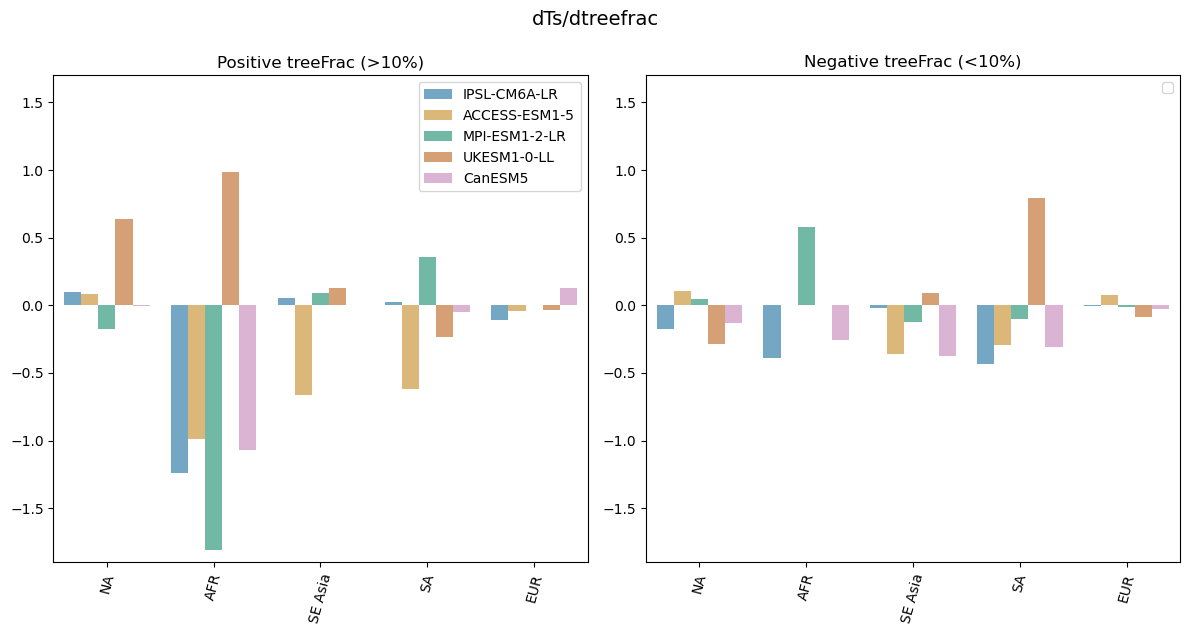

In [61]:
import seaborn as sns

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
        data=dTs_tree_pos_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(regions, rotation = 75)
ax0.set_ylim(-1.9, 1.7)
ax0.legend(loc='upper right', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
ax0.set_title("Positive treeFrac (>10%)")


ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
        data=dTs_tree_neg_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6,
    )
ax1.set_xticklabels(regions , rotation = 75)
ax1.set_ylim(-1.9, 1.7)
ax1.legend("")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Negative treeFrac (<10%)")

fig.tight_layout()
title = 'dTs/dtreefrac'
fig.suptitle(title, y = 1.05, fontsize = 14)

### Seasons

In [108]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]
seasons = ["DJF", "MAM", "JJA", "SON"]
boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

dTs_tree_seas_pos = []
dTs_tree_seas_neg = []

for i, model in enumerate(models):
    seas_pos = []; seas_neg = []
    for bb, box in enumerate(boxes):
        pos = []; neg = []
        for season in ["DJF", "MAM", "JJA", "SON"]:
            pos.append(dTs_tree_seas[i][season]["coef"].sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).where(mask_treefrac_pos[i].notnull()).mean().compute().data)
            neg.append(dTs_tree_seas[i][season]["coef"].sel(lon=slice(box[0], box[1]), lat=slice(box[2], box[3])).where(mask_treefrac_neg[i].notnull()).mean().compute().data)
            
        seas_pos.append(pd.DataFrame(pos))
        seas_neg.append(pd.DataFrame(neg))
        
    seas_pos = pd.concat(seas_pos, axis = 1).set_axis(seasons, axis = 0).set_axis(regions, axis = 1)
    seas_neg = pd.concat(seas_neg, axis = 1).set_axis(seasons, axis = 0).set_axis(regions, axis = 1)
    seas_pos["model"] = model
    seas_neg["model"] = model
    seas_pos = seas_pos.reset_index(names = "season")
    seas_neg = seas_neg.reset_index(names = "season")
    
    dTs_tree_seas_pos.append(seas_pos)
    dTs_tree_seas_neg.append(seas_neg)
    

In [104]:
dTs_tree_seas_pos = pd.concat(dTs_tree_seas_pos) 
dTs_tree_seas_neg = pd.concat(dTs_tree_seas_neg)

dTs_tree_seas_pos = dTs_tree_seas_pos.reset_index(names = "season")
dTs_tree_seas_pos = pd.melt(dTs_tree_seas_pos, id_vars = ["season", "model"], var_name = "region")
dTs_tree_seas_pos

Text(0.45, 1.05, 'Seasonal dTs/dtreeFrac (treeFrac >10%)')

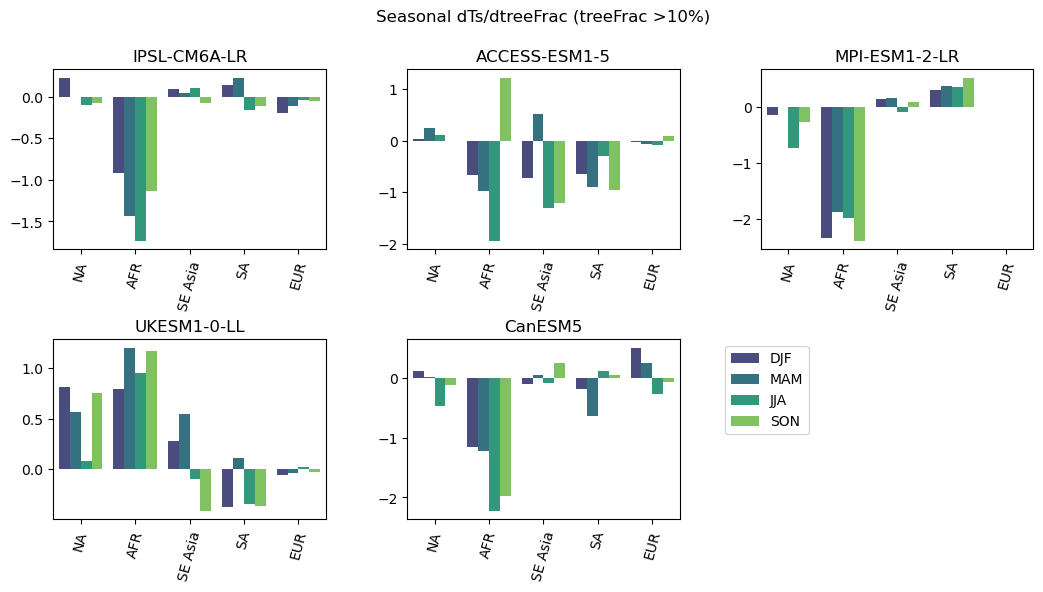

In [128]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m,mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=pd.melt(dTs_tree_seas_pos[m],id_vars = ["season", "model"], var_name = "region"), hue = pd.melt(dTs_tree_seas_pos[m],id_vars = ["season", "model"], var_name = "region").season,# errorbar=("pi", 50),
            x="region", y="value",
            palette="viridis", alpha=1,
        )
        axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(mm)
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=pd.melt(dTs_tree_seas_pos[m],id_vars = ["season", "model"], var_name = "region"), hue = pd.melt(dTs_tree_seas_pos[m],id_vars = ["season", "model"], var_name = "region").season,# errorbar=("pi", 50),
            x="region", y="value",
            palette="viridis", alpha=1,
        )
        axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(mm)
        
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
        
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("Seasonal dTs/dtreeFrac (treeFrac >10%)", y =1.05, x = 0.45)

## cor(Ts, $\Delta$treefrac)

In [55]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]
corTs_tree_pos_esm = []
corTs_tree_neg_esm = []
for i in np.arange(len(models)):
    content_pos = []
    content_neg = []
    for b in boxes:
        content_pos.append(dTs_tree[i]['cor'].where(mask_treefrac_pos[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
        content_neg.append(dTs_tree[i]['cor'].where(mask_treefrac_neg[i].notnull()).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).mean().compute().data)
    corTs_tree_pos_esm.append(pd.DataFrame(content_pos))
    corTs_tree_neg_esm.append(pd.DataFrame(content_neg))


corTs_tree_pos_esm = pd.concat(corTs_tree_pos_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
corTs_tree_neg_esm = pd.concat(corTs_tree_neg_esm, axis = 1).set_axis(models, axis = 1).set_axis(regions, axis = 0)
corTs_tree_pos_esm["regions"] = corTs_tree_pos_esm.index
corTs_tree_neg_esm["regions"] = corTs_tree_neg_esm.index
corTs_tree_pos_esm = pd.melt(corTs_tree_pos_esm, id_vars="regions", var_name="esm")
corTs_tree_neg_esm = pd.melt(corTs_tree_neg_esm, id_vars="regions", var_name="esm")

Text(0.5, 1.05, 'cor(Ts,dtreefrac)')

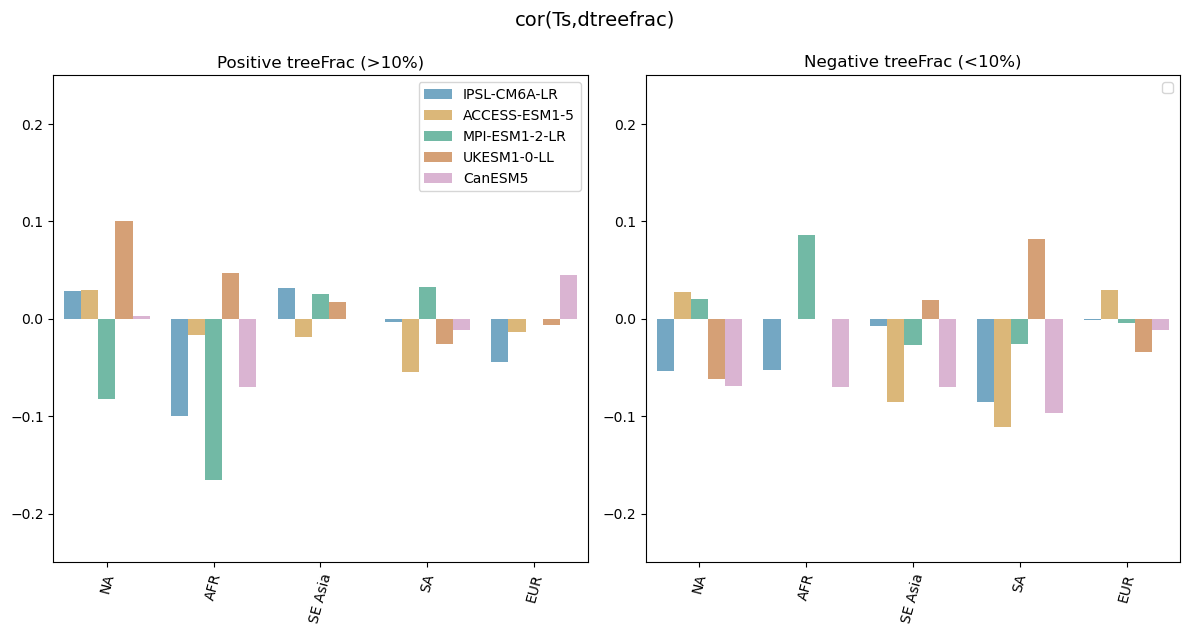

In [59]:
import seaborn as sns

fig = plt.figure(figsize=(12, 6))
ax0 = fig.add_subplot(121)
ax0 = sns.barplot(
        data=corTs_tree_pos_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6, 
    )
ax0.set_xticklabels(regions, rotation = 75)
ax0.set_ylim(-0.25, 0.25)
ax0.legend(loc='upper right', fontsize = 10)
ax0.set_xlabel("")
ax0.set_ylabel("")
ax0.set_title("Positive treeFrac (>10%)")


ax1 = fig.add_subplot(122)
ax1 = sns.barplot(
        data=corTs_tree_neg_esm, hue = "esm",# errorbar=("pi", 50),
        x="regions", y="value",
        palette="colorblind", alpha=.6,
    )
ax1.set_xticklabels(regions , rotation = 75)
ax1.set_ylim(-0.25, 0.25)
ax1.legend("")
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_title("Negative treeFrac (<10%)")

fig.tight_layout()
title = 'cor(Ts,dtreefrac)'
fig.suptitle(title, y = 1.05, fontsize = 14)

## reg(SEB, $\Delta$treefrac)

### Regions

In [17]:
%%capture

dseb_tree = []
dTs_seb = []
for m,_ in enumerate(models):
    
    # difference in treeFrac in aff vs ctl
    dtree_frac = (xr_aff_pft[m]["treeFrac"] - xr_ctl_pft[m]["treeFrac"])

    # sensitivity of SEB components to delta_treeFrac
    coef1 = xr.Dataset()
    coef2 = xr.Dataset()
    for v in ["albedo","hfls","hfss","rlds","pr"]:
        delta = (xr_aff[m][v] - xr_ctl[m][v])/(xr_aff[m][v] - xr_ctl[m][v]).std(dim = "time")
        coef1[v] = lag_linregress_3D(delta, dtree_frac)['coef']
        coef2[v] = lag_linregress_3D(dT_model_esm[m], delta)['coef']
        # dseb_pval[k] = lag_linregress_3D(seb_effect_esm[m][k], dtree_frac)["pval"]
    dseb_tree.append(coef1)
    dTs_seb.append(coef2)
    # dseb_tree_pval.append(dseb_pval)

In [61]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

dseb_tree_pos_esm = []
dseb_tree_neg_esm = []
for i,mm in enumerate(models):
    content = []
    content1 = []
    for bb,b in enumerate(boxes):
        content.append((dseb_tree[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_pos[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
        content1.append((dseb_tree[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_neg[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
    content = pd.concat(content,axis = 1)
    content1 = pd.concat(content1,axis = 1)
    
    if hasattr(content, "plev"):
        content = content.drop(columns = ["plev"])
        content1 = content1.drop(columns = ["plev"])
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    
    content["model"] = models[i]
    content1["model"] = models[i]
    
    dseb_tree_pos_esm.append(content)
    dseb_tree_neg_esm.append(content1)

dseb_tree_pos_esm = pd.concat(dseb_tree_pos_esm, axis = 0)
dseb_tree_pos_esm = pd.melt(dseb_tree_pos_esm, ignore_index=False, id_vars="model", var_name="regions")

dseb_tree_neg_esm = pd.concat(dseb_tree_neg_esm, axis = 0)
dseb_tree_neg_esm = pd.melt(dseb_tree_neg_esm, ignore_index=False, id_vars="model", var_name="regions")

Text(0.45, 1.05, 'dSEB/dtreeFrac (treeFrac >10%)')

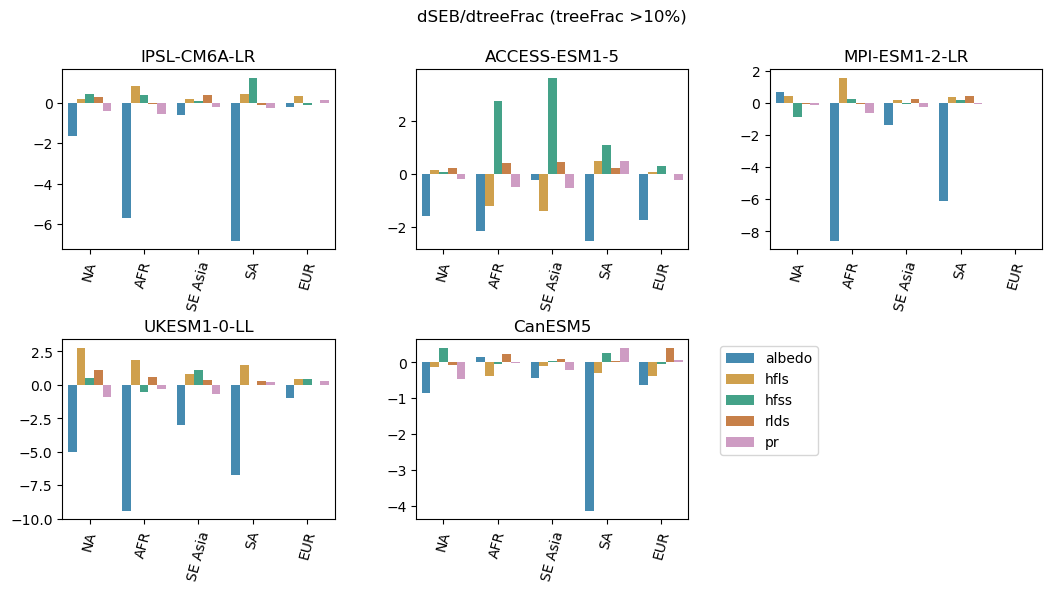

In [62]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=dseb_tree_pos_esm[dseb_tree_pos_esm["model"] == models[m]], hue = dseb_tree_pos_esm[dseb_tree_pos_esm["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8,
        )
        axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=dseb_tree_pos_esm[dseb_tree_pos_esm["model"] == models[m]], hue = dseb_tree_pos_esm[dseb_tree_pos_esm["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8, 
        )
        axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("dSEB/dtreeFrac (treeFrac >10%)", y =1.05, x = 0.45)

## reg(Ts, SEB)

In [75]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

dTs_seb_pos_esm = []
dTs_seb_neg_esm = []
for i,mm in enumerate(models):
    content = []
    content1 = []
    for bb,b in enumerate(boxes):
        content.append((dTs_seb[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_pos[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
        content1.append((dTs_seb[i].sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3])).where(mask_treefrac_neg[i].notnull()).mean())
                                .compute().to_array().to_dataframe(name = regions[bb]).drop(columns = ["height"]))
    content = pd.concat(content,axis = 1)
    content1 = pd.concat(content1,axis = 1)
    
    if hasattr(content, "plev"):
        content = content.drop(columns = ["plev"])
        content1 = content1.drop(columns = ["plev"])
    if hasattr(content, "type"):
        content = content.drop(columns = ["type"])
        content1 = content1.drop(columns = ["type"])
    
    content["model"] = models[i]
    content1["model"] = models[i]
    
    dTs_seb_pos_esm.append(content)
    dTs_seb_neg_esm.append(content1)

dTs_seb_pos_esm = pd.concat(dTs_seb_pos_esm, axis = 0)
dTs_seb_pos_esm = pd.melt(dTs_seb_pos_esm, ignore_index=False, id_vars="model", var_name="regions")

dTs_seb_neg_esm = pd.concat(dTs_seb_neg_esm, axis = 0)
dTs_seb_neg_esm = pd.melt(dTs_seb_neg_esm, ignore_index=False, id_vars="model", var_name="regions")

Text(0.45, 1.05, 'dTs/dSEB (treeFrac >10%)')

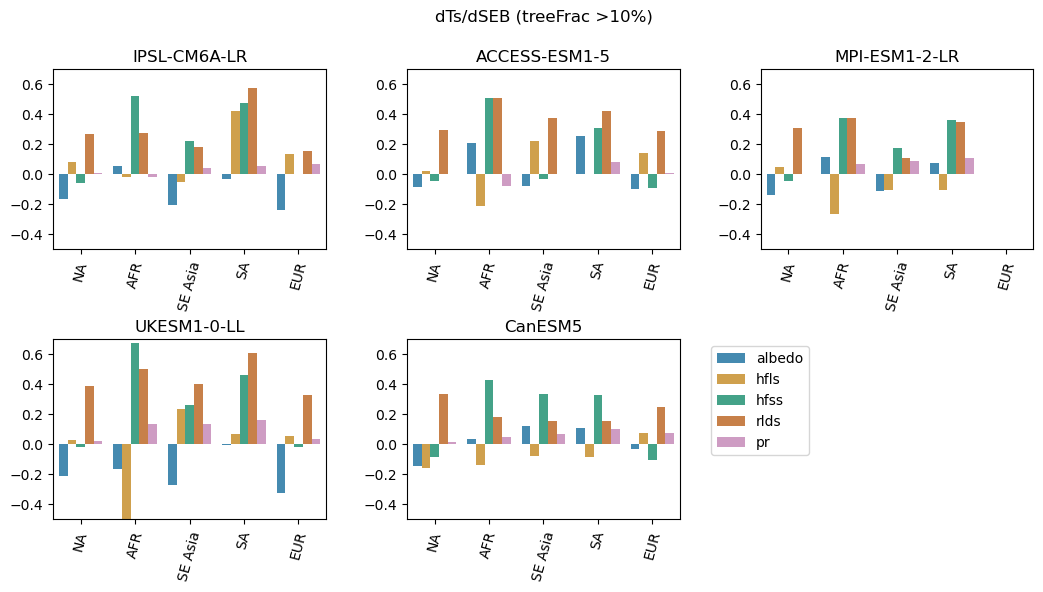

In [78]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
    
for m, mm in enumerate(models):
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.barplot(
            data=dTs_seb_pos_esm[dTs_seb_pos_esm["model"] == models[m]], hue = dTs_seb_pos_esm[dTs_seb_pos_esm["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8,
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.barplot(
            data=dTs_seb_pos_esm[dTs_seb_pos_esm["model"] == models[m]], hue = dTs_seb_pos_esm[dTs_seb_pos_esm["model"] == models[m]].index,# errorbar=("pi", 50),
            x="regions", y="value",
            palette="colorblind", alpha=.8,
        )
        axs.set_xticklabels(regions, rotation = 75)
        axs.set_ylim(-0.5, 0.7)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("")
        axs.set_ylabel("")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
# fig.tight_layout()
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
fig.suptitle("dTs/dSEB (treeFrac >10%)", y =1.05, x = 0.45)

## Disentangle climatic contributions for Ts and pr change

#### Regions

In [60]:
%%capture
regions = ["NA", "AFR", "SE Asia", "SA", "EUR"]

boxes = [
        (-130, -60, 30, 60),    # NA
        (-20, 50, -25, 20),     # Africa
        (90, 130, 10, 40),       # SEAsia
        (-85, -35, -40, 10),       # SA
        (10, 60, 40, 70)       # Eurasia
]

df_delta_pos = []
df_delta_neg = []
for i,mm in enumerate(models):
    content = {}
    content1 = {}
    for bb,b in enumerate(boxes):
        content[regions[bb]] = ((xr.merge([xr_delta[i],xr_delta_pft[i]]).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
                              .where(mask_treefrac_pos[i].notnull())
                              .stack(cell=["lon", "lat"])).compute().dropna(dim='cell')).to_dataframe().drop(columns = ["lon", "lat","height"])
        content1[regions[bb]] = ((xr.merge([xr_delta[i],xr_delta_pft[i]]).sel(lon = slice(b[0], b[1]), lat = slice(b[2], b[3]))
                              .where(mask_treefrac_neg[i].notnull())
                              .stack(cell=["lon", "lat"])).compute().dropna(dim='cell')).to_dataframe().drop(columns = ["lon", "lat","height"])
    
    df_delta_pos.append(content)
    df_delta_neg.append(content1)

<AxesSubplot:>

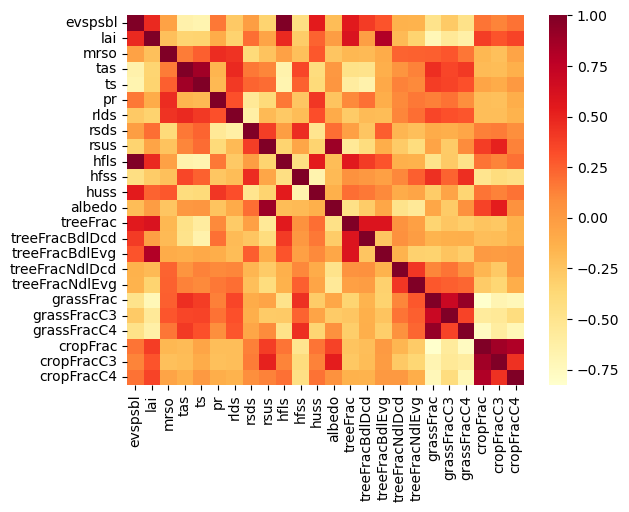

In [109]:
import seaborn as sns
sns.heatmap(df_delta_pos[0].reset_index().drop(columns = ["type","lon","lat"]).corr(), annot=False, fmt=".1f", cmap = "YlOrRd")

Text(0.45, 1.05, 'Ts - positive treeFrac >10%')

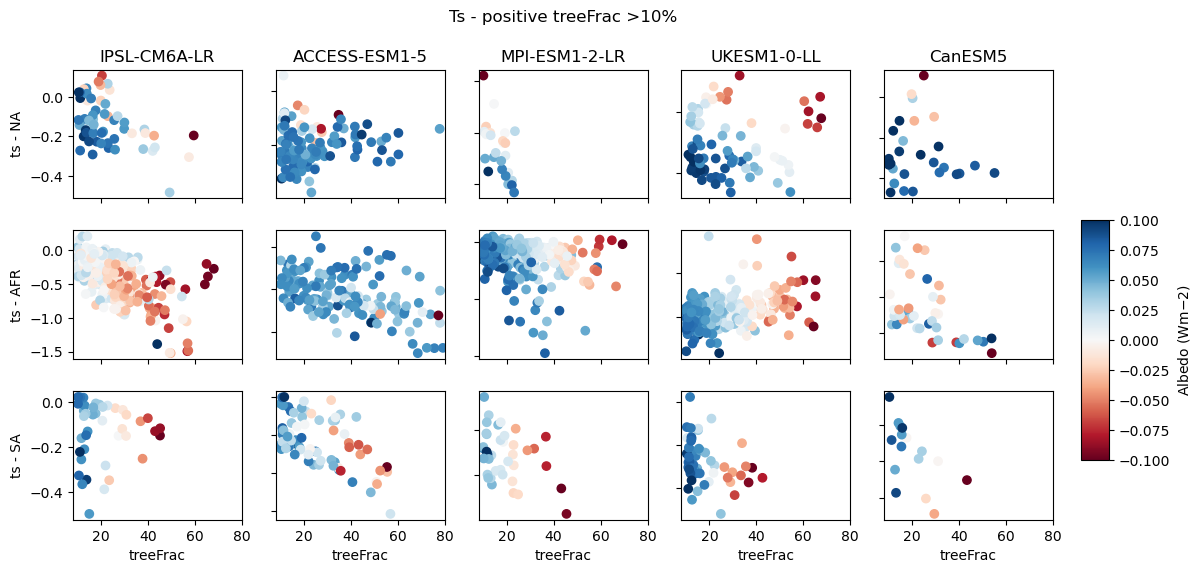

In [81]:
indices = [0,1,3]
regions_pos = [regions[i] for i in indices]

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(3, 5)

cmap = "RdBu"
norm = colors.Normalize(vmin=-0.1, vmax=0.1)

for m, mm in enumerate(models):
    for r, rr in enumerate(regions_pos):
        data=df_delta_pos[m][rr]
        
        axs = fig.add_subplot(gs[r,m])
        scatter = axs.scatter(
                             x = data["treeFrac"],
                             y = data["ts"],
                             c = data["albedo"],
                             cmap = cmap
                            
        )
        # axs.set_ylim(-1, 1)
        axs.set_xlim(8, 80)
        # axs.legend(loc='upper right', fontsize = 10)
        # axs.legend_.remove()
        axs.set_xlabel("treeFrac")
        axs.set_ylabel("ts"+ " - " + rr)
        if r == 0:
            axs.set_title(models[m])
        axs.label_outer()

# fig.tight_layout()
cbar_ax = fig.add_axes([0.82, 0.3, 0.02, 0.4])  # Adjust these values to position your colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Albedo (Wm${-2}$)")
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.2, hspace=0.25)
fig.suptitle("Ts - positive treeFrac >10%", y =1.05, x = 0.45)

Text(0.45, 1.05, 'pr - positive treeFrac >10%')

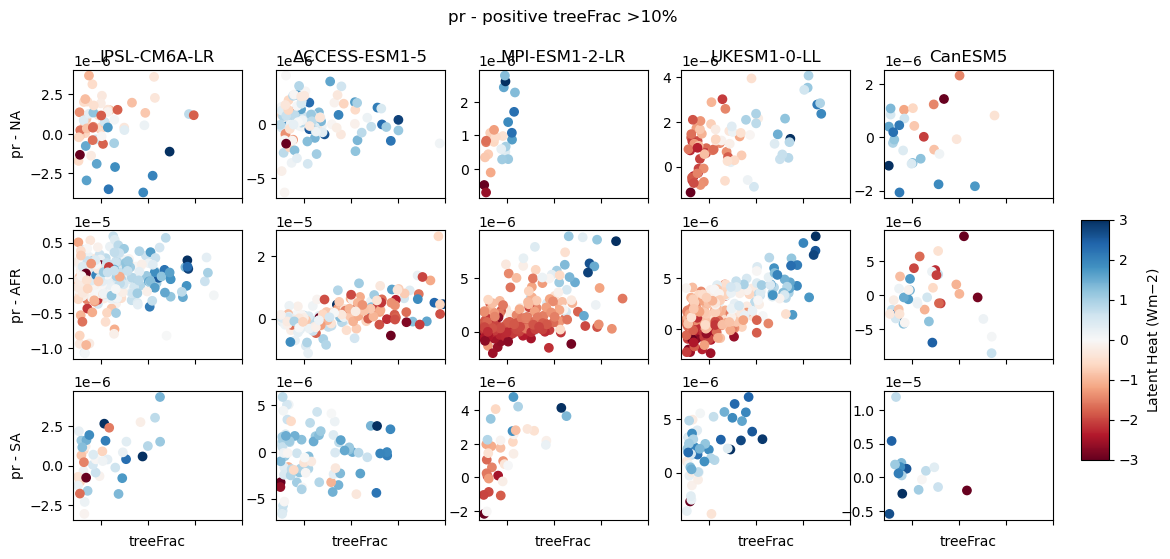

In [211]:
indices = [0,1,3]
regions_pos = [regions[i] for i in indices]

width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(3, 5)

cmap = "RdBu"
norm = colors.Normalize(vmin=-3, vmax=3)

for m, mm in enumerate(models):
    for r, rr in enumerate(regions_pos):
        data=df_delta_pos[m][rr]
        
        axs = fig.add_subplot(gs[r,m])
        scatter = axs.scatter(
                             x = data["treeFrac"],
                             y = data["pr"],
                             c = data["hfls"],
                             cmap = cmap
                            
        )
        # axs.set_ylim(-1*10**-5, 1*10**-5)
        axs.set_xlim(8, 80)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.set_ylabel("")
        if m == 0:
            axs.set_ylabel("pr"+ " - " + rr)
        if r == 2:
            axs.set_xlabel("treeFrac")
        if r == 0:
            axs.set_title(models[m])
        # axs.label_outer()
        
        axs.set_xticklabels("")
# fig.tight_layout()
cbar_ax = fig.add_axes([0.82, 0.3, 0.02, 0.4])  # Adjust these values to position your colorbar
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar.set_label("Latent Heat (Wm${-2}$)")
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.2, hspace=0.25)
fig.suptitle("pr - positive treeFrac >10%", y =1.05, x = 0.45)

Text(0.45, 1.05, 'negative treeFrac >10%')

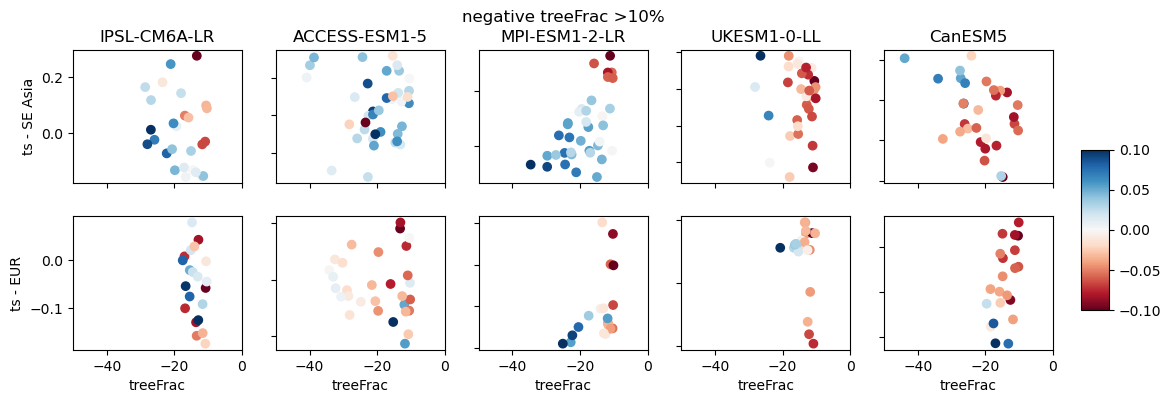

In [170]:
indices = [2,4]
regions_neg = [regions[i] for i in indices]

width_inch = 14
height_inch = 4

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 5)

cmap = "RdBu"
norm = colors.Normalize(vmin=-0.1, vmax=0.1)

for m, mm in enumerate(models):
    for r, rr in enumerate(regions_neg):
        data=df_delta_neg[m][rr]
        
        axs = fig.add_subplot(gs[r,m])
        scatter = axs.scatter(
                             x = data["treeFrac"],
                             y = data["ts"],
                             c = data["albedo"],
                             cmap = cmap
                            
        )
        # axs.set_ylim(-1, 1)
        axs.set_xlim(-50, 0)
        # axs.legend(loc='upper right', fontsize = 10)
        # axs.legend_.remove()
        axs.set_xlabel("treeFrac")
        axs.set_ylabel("ts"+ " - " + rr)
        if r == 0:
            axs.set_title(models[m])
        axs.label_outer()

# fig.tight_layout()
cbar_ax = fig.add_axes([0.82, 0.3, 0.02, 0.4])  # Adjust these values to position your colorbar
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.2, hspace=0.25)
fig.suptitle("negative treeFrac >10%", y =1.05, x = 0.45)

In [322]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the data
to_plot_scaled = scaler.fit_transform(df_delta_pos[3]["AFR"][["hfls","hfss","huss","pr","rlds","rsds","ts","albedo", "treeFrac"]])
df_scaled = pd.DataFrame(to_plot_scaled, columns=df_delta_pos[3]["AFR"][["hfls","hfss","huss","pr","rlds","rsds","ts","albedo", "treeFrac"]].columns)

pca = PCA(n_components=2)
pca.fit(df_scaled)

pca_scores = pca.transform(df_scaled)
pca_loadings = pca.components_[:2].T

pca_df = pd.DataFrame(pca_scores).rename(columns = {0:"PC1", 1:"PC2"})
# pca = pca.rename(index=dict(zip(pca.index, esm)))
pca_df = pd.concat([pca_df, df_scaled], axis = 1)

print("Variance explained is:", pca.explained_variance_ratio_)
print("PC coefficients are:", pca.components_)
pca_df.head(2)

Variance explained is: [0.53971785 0.1712247 ]
PC coefficients are: [[ 0.42185283 -0.35041052  0.3037508   0.39629218  0.33202094 -0.20561948
   0.1512731  -0.3593263   0.38134572]
 [-0.14679709  0.34114236 -0.35606807 -0.21967538  0.1742453   0.10767099
   0.6514436  -0.37660396  0.28083393]]


,PC1,PC2,hfls,hfss,huss,pr,rlds,rsds,ts,albedo,treeFrac
0,0.382925,-0.078486,0.155229,-0.136598,0.145587,-0.391663,1.170148,-0.447991,-0.195915,0.17382,-0.020894
1,-0.839070,-1.873407,-0.186330,-0.187077,0.497438,-0.286462,0.673817,-0.279348,-1.432885,1.72548,-0.807635


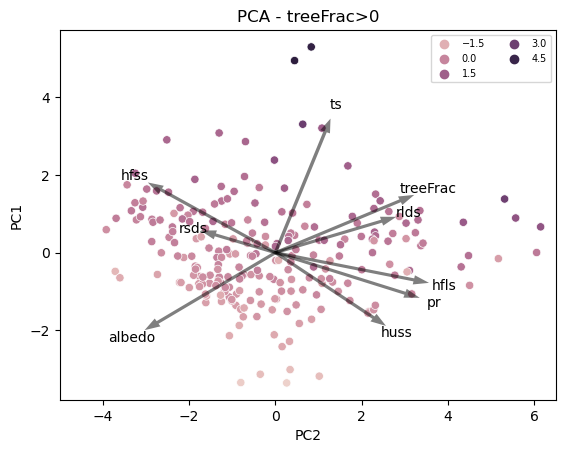

In [323]:
arrows = pca_loadings * np.abs(pca_scores).max(axis=0)
features = df_scaled.columns.values


fig, ax = plt.subplots(nrows=1, ncols=1)
ax = sns.scatterplot(data=pca_df, x = "PC1", y= "PC2", hue=pca_df.ts)

for i, arrow in enumerate(arrows):
    plt.arrow(0, 0, *arrow, color='k', alpha=0.5, width=0.08, ec='none',
              length_includes_head=True)
    plt.text(*(arrow * 1.1), features[i], 
             ha='center', va='center')

ax.set(xlabel= "PC2", ylabel='PC1')
title= "PCA - treeFrac>0"
ax.set_title(title)
ax.set_xlim(-5, 6.5)
ax.legend(loc='upper right', ncol=2, fontsize = 7)
# output_file = os.path.join(out_path, title) + ".png"
# plt.savefig(output_file, bbox_inches='tight')


#### Water vs Energy limited

In [49]:
%%capture

df_delta_pos_water = []
df_delta_pos_energy = []
for m,mm in enumerate(models):
    mask = mask_treefrac_pos[m].notnull() & mask_aff_water[m].notnull()
    mask1 = mask_treefrac_pos[m].notnull() & mask_aff_energy[m].notnull()

    masked = xr.merge([xr_delta[m],xr_delta_pft[m]]).where(mask)
    masked1 = xr.merge([xr_delta[m],xr_delta_pft[m]]).where(mask1)
    
    content = (masked.stack(cell=["lon", "lat"]).compute().dropna(dim='cell')).to_dataframe().drop(columns = ["lon", "lat"])
    content1 = (masked1.stack(cell=["lon", "lat"]).compute().dropna(dim='cell')).to_dataframe().drop(columns = ["lon", "lat"])

    content["regime"] = "water-lim"
    content1["regime"] = "energy-lim"
    df_delta_pos_water.append(content)
    df_delta_pos_energy.append(content1)

# df_delta_pos_water = pd.DataFrame(df_delta_pos_water, columns = list(seb_effect_esm[m].data_vars)[:], index = models)
# df_delta_pos_energy = pd.DataFrame(df_delta_pos_energy, columns = list(seb_effect_esm[m].data_vars)[:], index = models)

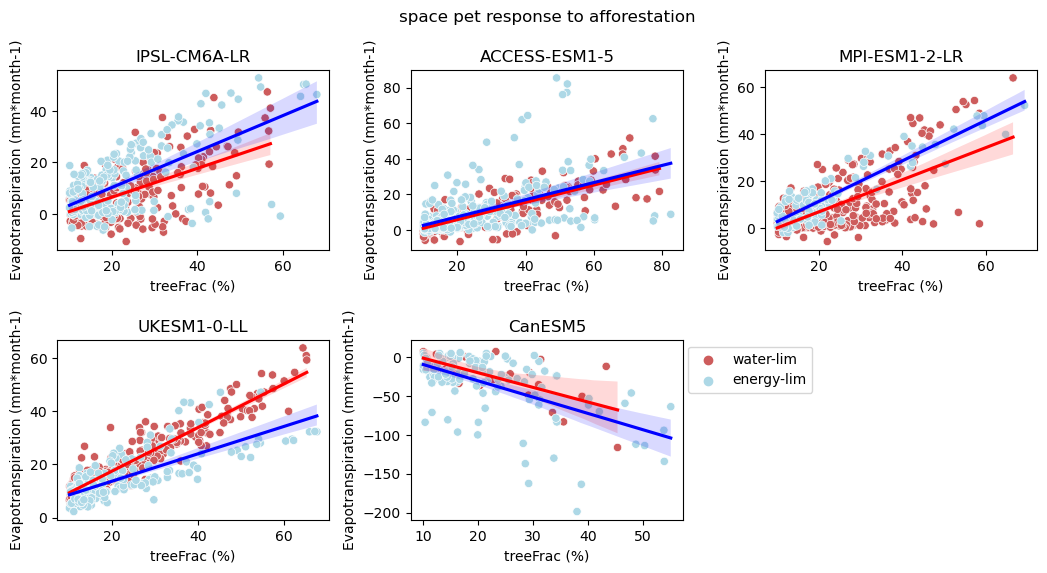

In [61]:
width_inch = 14
height_inch = 6

fig = plt.figure(figsize=(width_inch, height_inch)) #, constrained_layout=True)
gs = gridspec.GridSpec(2, 3)
var = "pet"
for m, mm in enumerate(models):
    df = pd.concat([df_delta_pos_water[m], df_delta_pos_energy[m]], axis = 0)
    
    if m < 3:
        axs = fig.add_subplot(gs[0, m])
        axs = sns.scatterplot(data=df, x='treeFrac', y=var, hue='regime', palette=['indianred', 'lightblue'])
        axs = sns.regplot(data = df[df["regime"] == "water-lim"], x="treeFrac", y=var, scatter=False, line_kws={"color": "red"})
        axs = sns.regplot(data = df[df["regime"] == "energy-lim"], x="treeFrac", y=var, scatter=False, line_kws={"color": "blue"})

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-1, 1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("treeFrac (%)")
        axs.set_ylabel("Evapotranspiration (mm*month-1)")
        axs.set_title(models[m])
    else:
        axs = fig.add_subplot(gs[1, m-3])
        axs = sns.scatterplot(data=df, x='treeFrac', y=var, hue='regime', palette=['indianred', 'lightblue'])
        axs = sns.regplot(data = df[df["regime"] == "water-lim"], x="treeFrac", y=var, scatter=False, line_kws={"color": "red"})
        axs = sns.regplot(data = df[df["regime"] == "energy-lim"], x="treeFrac", y=var, scatter=False, line_kws={"color": "blue"})

        # axs.set_xticklabels(regions, rotation = 75)
        # axs.set_ylim(-1, 1)
        # axs.legend(loc='upper right', fontsize = 10)
        axs.legend_.remove()
        axs.set_xlabel("treeFrac (%)")
        axs.set_ylabel("Evapotranspiration (mm*month-1)")
        axs.set_title(models[m])
    if m == 4:
        axs.legend(loc='upper right', bbox_to_anchor=(1.5, 1) ,fontsize = 10)
    
fig.subplots_adjust(bottom=0.2, top=0.95, left=0.1, right=0.8, wspace=0.3, hspace=0.5)
title = "space " + var + " response to afforestation"
fig.suptitle(title, y =1.05, x = 0.45)

output_file = os.path.join(out_path, title) + ".png"
plt.savefig(output_file, bbox_inches='tight')
    
plt.show()
plt.close()